This week the question came up in the lab of how well the conformer generation code scales with the number of threads used. Since generating conformers is embarassingly parallel - the conformers don't depend on each other (this isn't quite true if you are doing RMS pruning) - in a perfect world you'd expect more or less linear scaling. So theoretically using 4 times as many threads should take 1/4 as long as long as the number of threads is used than the number of conformers being generated. In reality, things don't quite work out this way since the individual conformers can take different amounts of time to generate due to the stochastic nature of the RDKit's distance-geometry-based algorithm.

I decided to do a quick test to see how well things scale on my machine.

In [12]:
import gzip
from rdkit import Chem
from rdkit.Chem import rdDistGeom

import time
from tqdm import tqdm

from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('tableau-colorblind10')

import rdkit
print(rdkit.__version__)

2025.03.5


Start by loading some molecules. This is a set of 370 molecules that are present in both the [COD](https://www.crystallography.net/cod/) and [ChEMBL](https://www.ebi.ac.uk/chembl/). I use these (as well as some other COD subsets) a lot for confgen testing:

In [7]:
ms = [x for x in Chem.ForwardSDMolSupplier(gzip.open('../data/COD_2025Jan13.organic.chembl_selected.sdf.gz'),
                                          removeHs=False) if x is not None]
len(ms)

370

For the purposes of this post we'll just use 100 of the COD molecules. Add Hs to the mols and create the subset:

In [9]:
ms = [Chem.AddHs(m) for m in ms]
ms = ms[:100]

My linux box has 8 performance cores (each of which can run two hyperthreads) and 8 "efficient" cores, so python thinks I have 24 CPUs available:

In [10]:
import multiprocessing
multiprocessing.cpu_count()

24

I will try thread counts up to 10 to check scaling; a bit beyond the number of physical performance cores on my machine. 

Now try generating both 100 conformer and 400 conformer sets for each molecule using different thread counts and track how long it takes:

In [15]:
threadCounts = [1,2,4,6,8,10]

params = rdDistGeom.ETKDGv3()
params.randomSeed = 0xa100f

tgtConfs = (100,400)
accum = {}
for tgt in tgtConfs:
    print(f"Doing {tgt} conformers")
    accum[tgt] = {}
    for tc in threadCounts:
        params.numThreads = tc
        accum[tgt][tc] = []
        print(f"Doing {tc} threads")
        for m in tqdm(ms):
            t1 = time.time()
            rdDistGeom.EmbedMultipleConfs(m,tgt,params)
            t2 = time.time()
            accum[tgt][tc].append(t2-t1)
        print(f'\t{sum(accum[tgt][tc]):.1f}')

Doing 100 conformers
Doing 1 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:39<00:00,  1.59s/it]


	159.0
Doing 2 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:25<00:00,  1.18it/s]


	85.0
Doing 4 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:46<00:00,  2.17it/s]


	46.1
Doing 6 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:32<00:00,  3.09it/s]


	32.3
Doing 8 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:26<00:00,  3.74it/s]


	26.7
Doing 10 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:27<00:00,  3.67it/s]


	27.2
Doing 400 conformers
Doing 1 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [10:29<00:00,  6.30s/it]


	629.9
Doing 2 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [05:32<00:00,  3.32s/it]


	332.1
Doing 4 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [02:52<00:00,  1.72s/it]


	172.4
Doing 6 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:58<00:00,  1.18s/it]


	118.4
Doing 8 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:38<00:00,  1.02it/s]


	98.1
Doing 10 threads


100%|█████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:45<00:00,  1.05s/it]

	105.4


Calculate the relative runtime for each molecule with each threadcount. If everything is scaling perfectly, we'd expect doubling the number of threads to cut the runtime in half.

In [16]:
factors = {}
for nc in accum:
    factors[nc] = {}
    for tc in accum[nc]:
        if tc==1:
            factors[nc][tc] = [1]*len(ms)
        else:
            factors[nc][tc] = []
            for i,m in enumerate(ms):
                factors[nc][tc].append(accum[nc][tc][i]/accum[nc][1][i])
            


Now plot the results.

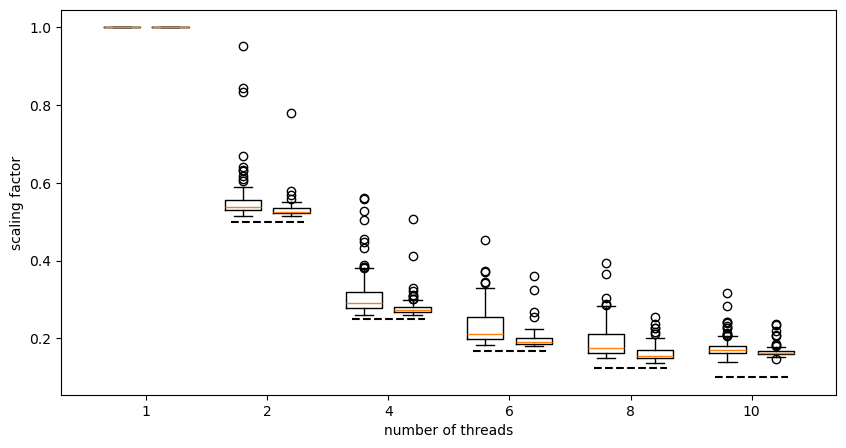

In [49]:
plt.figure(figsize=(10,5))
xp = [1+x-0.2 for x in range(len(threadCounts))]
widths = [0.3 for x in range(len(threadCounts))]
plt.boxplot([factors[100][tc] for tc in threadCounts],positions=xp,widths=widths,label='100 conformers');
xp = [1+x+0.2 for x in range(len(threadCounts))]
plt.boxplot([factors[400][tc] for tc in threadCounts],positions=xp,widths=widths,label='400 conformers');
plt.xticks(range(1, len(threadCounts) + 1),[str(x) for x in threadCounts]);
plt.xlabel('number of threads');
plt.ylabel('scaling factor')
plt.plot((1.7,2.3),(0.5,0.5),'k--');
plt.plot((2.7,3.3),(0.25,0.25),'k--');
plt.plot((3.7,4.3),(1/6,1/6),'k--');
plt.plot((4.7,5.3),(1/8,1/8),'k--');
plt.plot((5.7,6.3),(1/10,1/10),'k--');

The left-hand boxplot in each column is the results for 100 conformers, the right-hand boxplot is for 400 conformers. The dashed line in each column shows what you would expect for perfect scaling.

We can see that on my machine with these molecules the scaling is pretty good up to about 6 threads but that by the time we get to 10 threads we're deviating pretty strongly from perfect scaling. In fact, the runtime for 10 threads isn't massively better than it is for 8 (the number of physical performance cores in my machine). Unsurprisingly, the scaling is better for 400 conformers than it is for 100, but even with 400 conformers it's not really worth increasing from 8 to 10 threads on my machine.

Based on this analysis, I'd probably go with using either 6 or 8 threads for future confgen work on this machine.